In [2]:
# Import needed packages for analysis
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib

import cfl.util.brain_util as BU
import cfl.util.brain_vis as BV

# load response data 
Y = pd.read_pickle('Y.pkl')

behav_csv = 'PTSD_Data_Share\Behavior_data\PTSD_PerLight.csv'
mri_dir = 'PTSD_Data_Share\MEMRI_data'

# load one image to check out its dimensions
img = BU.load_brain(os.path.join(mri_dir, "PTSD_KO_03_BL.nii"), ori='RPS')
mri_dims = img.shape
print(mri_dims)

# load all the images in RAS orientation 
X, Y_unused = BU.load_data(mri_dir, behav_csv, mri_dims, ori='RPS')

(124, 200, 82)


# knockout corrs

voxel and corr value 
56, 151, 60  = 0.8667

In [20]:
# timepoints dir
baseline_indices = Y[Y["Timepoint"]=="BL"].index.tolist()
prefear_indices = Y[Y["Timepoint"]=="PreF"].index.tolist()
postfear_indices = Y[Y["Timepoint"]=="Fear"].index.tolist()
d9_indices = Y[Y["Timepoint"]=="D9"].index.tolist() 
timepoints_dir = {'BL' : baseline_indices, 'PreF': prefear_indices, "Fear": postfear_indices, 'D9': d9_indices}

# function to get the indices for each timepoint/genotype
def indices_by_genotype_timepoint(X, Y): 
    baseline_indices = Y[Y["Timepoint"]=="BL"].index.tolist()
    prefear_indices = Y[Y["Timepoint"]=="PreF"].index.tolist()
    postfear_indices = Y[Y["Timepoint"]=="Fear"].index.tolist()
    d9_indices = Y[Y["Timepoint"]=="D9"].index.tolist() 
    timepoints_dir = {'BL' : baseline_indices, 'PreF': prefear_indices, "Fear": postfear_indices, 'D9': d9_indices}

    
    WT_indices = Y[Y["Genotype"]=="WT"].index.tolist()
    KO_indices = Y[Y["Genotype"]=="KO"].index.tolist() 

    agg_dir = {}
    for timepoint in timepoints_dir: 
        KO_key = timepoint + '_KO'
        KO_time_indices = list(set(KO_indices).intersection(set(timepoints_dir[timepoint])))
        agg_dir[KO_key] = KO_time_indices

        WT_key = timepoint + '_WT'
        WT_time_indices = list(set(WT_indices).intersection(set(timepoints_dir[timepoint])))
        agg_dir[WT_key] = WT_time_indices
    return agg_dir


indices_dir = indices_by_genotype_timepoint(X, Y)

In [27]:
Y_KO_diffs = Y.PerLight[(Y.Timepoint=="Fear") & (Y.Genotype=="KO")].to_numpy() - Y.PerLight[(Y.Timepoint=="PreF") & (Y.Genotype=="KO")].to_numpy()
X_KO_diffs = X[indices_dir['Fear_KO']] - X[indices_dir['PreF_KO']]

In [5]:
from scipy.stats import pearsonr

In [23]:
X_KO_diffs.shape

(10, 2033600)

In [24]:
X_KO_diffs_unflat = np.reshape(X_KO_diffs, (10, 124, 200, 82))

In [26]:
X_KO_diffs_unflat[:, 56, 151, 60]

array([  562.,   -54., -3253.,   637.,   609.,   257., -1868.,  1380.,
         330.,   184.], dtype=float32)

In [28]:
pearsonr(X_KO_diffs_unflat[:, 56, 151, 60], Y_KO_diffs)

(0.8214991390920858, 0.0035591596209353085)

In [29]:
corrs_KO = np.load('corrs_KO.npy')

In [31]:
BU.unflatten(corrs_KO, mri_dims)[56, 151, 60]

0.8214991390920858

Another voxel at corrs KO 

38, 80, 28 = 0.82028

In [32]:
pearsonr(X_KO_diffs_unflat[:, 38, 80, 28], Y_KO_diffs)

(-0.16921015623666774, 0.6402700409277601)

# Conclusion: the voxel locations that I'm seeing in FSL for the KO coordinates are not lining 

## Try again with the all-genotypes correlations (which is correctly oriented in FSL )


some values from FSL: 

(26, 137, 37) = 0.28109  
(31, 132, 40) = 0.49961

In [33]:
corrs_og = np.load('corrs_og.npy')

In [35]:
Y_diffs = Y.PerLight[timepoints_dir["Fear"]].to_numpy() - Y.PerLight[timepoints_dir["PreF"]].to_numpy()
X_diffs = X[timepoints_dir["Fear"]] - X[timepoints_dir["PreF"]]

X_diffs_unflat = np.reshape(X_diffs, (20, 124, 200, 82))

In [37]:
pearsonr(X_diffs_unflat[:, 26, 137, 37], Y_diffs)

(0.2810943831027688, 0.22992869740505514)

In [83]:
corr_current = pearsonr(X_diffs_unflat[:, 31, 132, 40], Y_diffs)

### Yes! These values correspond with what we see in the image when we view in FSL. Now let's look at them closer

In [66]:
X_unflat = np.reshape(X, (79, 124, 200, 82))

In [102]:
all_data = {'X_fear':  X_unflat[timepoints_dir["Fear"]][:, 26, 137, 37], 
        'X_prefear':  X_unflat[timepoints_dir["PreF"]][:, 26, 137, 37], 
        'X_diffs': X_diffs_unflat[:, 26, 137, 37], 
        'Y_fear': Y.PerLight[timepoints_dir["Fear"]].to_numpy(), 
        'Y_prefear': Y.PerLight[timepoints_dir["PreF"]].to_numpy(), 
        'Y_diffs': Y_diffs, 
        }

df = pd.DataFrame(all_data)
df

,X_fear,X_prefear,X_diffs,Y_fear,Y_prefear,Y_diffs
0,7764.0,7739.0,25.0,0.719592,0.840247,0.120656
1,8058.0,7254.0,804.0,0.958724,0.868174,-0.090550
2,6902.0,7879.0,-977.0,0.979551,0.496130,-0.483421
3,7266.0,7834.0,-568.0,0.898240,0.799589,-0.098651
4,8519.0,8034.0,485.0,0.854896,0.773725,-0.081171
5,7623.0,7970.0,-347.0,0.884018,0.694953,-0.189066
6,7749.0,7539.0,210.0,0.917001,0.439050,-0.477951
7,6694.0,8010.0,-1316.0,0.824071,0.845317,0.021246
8,9587.0,7785.0,1802.0,0.969095,0.793422,-0.175673
9,4967.0,7174.0,-2207.0,0.913290,0.555376,-0.357914


In [103]:
pearsonr(all_data['X_diffs'],-1* all_data['Y_diffs'])

(-0.2810943831027688, 0.22992869740505514)

In [76]:
df_small = pd.DataFrame(all_data, columns=['X_diffs', 'Y_diffs'])
df_small.sort_values(by=['X_diffs'], inplace=True)
df_small 

,X_diffs,Y_diffs
9,-2207.0,-0.357914
7,-1316.0,0.021246
12,-1189.0,-0.381507
2,-977.0,-0.483421
16,-896.0,-0.465572
17,-797.0,-0.210145
3,-568.0,-0.098651
19,-554.0,-0.030112
5,-347.0,-0.189066
0,25.0,0.120656


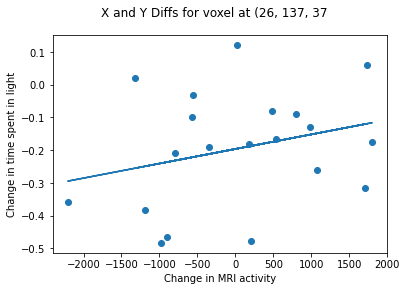

In [101]:
import matplotlib.lines as mlines
plt.scatter(all_data['X_diffs'], all_data['Y_diffs'])

m, b = np.polyfit(all_data['X_diffs'], all_data['Y_diffs'],  1)

#add linear regression line to scatterplot 
plt.plot(all_data['X_diffs'], m*all_data['X_diffs']+b)

plt.ylabel('Change in time spent in light')
plt.xlabel('Change in MRI activity')
plt.suptitle('X and Y Diffs for voxel at (26, 137, 37')
plt.show()

In [113]:
import scipy.ndimage as ndimage

X_smooth = np.zeros(X_unflat.shape)
for i, image in enumerate(X_unflat): 
    X_smooth[i] = ndimage.gaussian_filter(img, sigma=1)


np.save('X_smooth.npy', X_smooth)

In [109]:
X_smooth.shape

(79, 124, 200, 82)

In [117]:

# specify labels for plot (note the labels below are specifically for RAS orientation)
dir_labels = { 'saggital' :   ['P', 'A', 'D', 'V'],
               'coronal' :    ['L', 'R', 'D', 'V'],
               'horizontal' : ['L', 'R', 'A', 'P']} 

# Show first 5 baseline images 
BV.plot_interactive_panels(np.vstack((X[0], BU.flatten(X_smooth[1]))), mri_dims, np.ones(mri_dims), figsize=(15, 5), colormap="seismic", dir_labels=dir_labels, column_titles=["Mouse", "Smooth Mouse"])

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=123), Output(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=199), Output(…

interactive(children=(IntSlider(value=0, continuous_update=False, description='brain_slice', max=81), Output()…